In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pickle

# 1. 개체명 인식 데이터에 대한 이해와 전처리

In [ ]:
with open("C:/big15/project/member/KIM/multipocessing/entity_clean.pickle", "rb") as file:
    entity_clean = pickle.load(file)
entity_clean

,Sentence,Word,Tag
0,Sentence1,#0011,QT_PHONE
1,Sentence1,도교,O
2,Sentence1,킹,O
3,Sentence2,#0011,QT_PHONE
4,Sentence2,임창균,O
...,...,...,...
13239647,Sentence702061,#myhealer,O
13239648,Sentence702062,🥇등,QT_ORDER
13239649,Sentence702062,츄,O
13239650,Sentence702062,가해용,O


In [ ]:
print('데이터프레임 행의 개수 : {}'.format(len(entity_clean)))

데이터프레임 행의 개수 : 13239652


In [ ]:
print('데이터에 Null 값이 있는지 유무 : ' + str(entity_clean.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : False


In [ ]:
print('어떤 열에 Null값이 있는지 출력')
print('==============================')
entity_clean.isnull().sum()

어떤 열에 Null값이 있는지 출력


Sentence    0
Word        0
Tag         0
dtype: int64

In [ ]:
print('sentence # 열의 중복을 제거한 값의 개수 : {}'.format(entity_clean['Sentence'].nunique()))
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(entity_clean.Word.nunique()))
print('Tag 열의 중복을 제거한 값의 개수 : {}'.format(entity_clean.Tag.nunique()))

sentence # 열의 중복을 제거한 값의 개수 : 702062
Word 열의 중복을 제거한 값의 개수 : 586941
Tag 열의 중복을 제거한 값의 개수 : 151


In [ ]:
print('Tag 열의 각각의 값의 개수 카운트')
print('================================')
print(entity_clean.groupby('Tag').size().reset_index(name='count'))

Tag 열의 각각의 값의 개수 카운트
                   Tag  count
0        AFA_ART_CRAFT   1002
1         AFA_DOCUMENT  10172
2            AFA_MUSIC   7209
3      AFA_PERFORMANCE   2550
4            AFA_VIDEO  16016
..                 ...    ...
146      TR_HUMANITIES    421
147        TR_MEDICINE   2186
148          TR_OTHERS    203
149         TR_SCIENCE   3011
150  TR_SOCIAL_SCIENCE   1082

[151 rows x 2 columns]


In [ ]:
# 하나의 문장에 등장한 단어와 개체명 태깅 정보끼리 쌍(pair)으로 묶는 작업을 수행
func = lambda temp: [(w, t) for w, t in zip(temp["Word"].values.tolist(), temp["Tag"].values.tolist())]
tagged_sentences=[t for t in entity_clean.groupby("Sentence").apply(func)]
print("전체 샘플 개수: {}".format(len(tagged_sentences)))

전체 샘플 개수: 702062


In [ ]:
# 첫번째 샘플 출력
print(tagged_sentences[0])

[('#0011', 'QT_PHONE'), ('도교', 'O'), ('킹', 'O')]


In [ ]:
# 각 문장 샘플에서 단어는 sentences에 태깅 정보는 ner_tags에 저장
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 702062개의 문장 샘플을 1개씩 불러온다.

    # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentence, tag_info = zip(*tagged_sentence) 
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

In [ ]:
# 첫번째 문장 샘플을 출력
print(sentences[0])
print(ner_tags[0])

['#0011', '도교', '킹']
['QT_PHONE', 'O', 'O']


In [ ]:
# 임의로 98번 인덱스의 샘플에 대해서도 확인
print(sentences[98])
print(ner_tags[98])

['7만년 전', '호모', '사피', '엔', '스', '는', '생존', '을', '위해', '아프리카', '를', '탈출', '했다', '.']
['DT_OTHERS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


샘플의 최대 길이 : 743
샘플의 평균 길이 : 18.858238


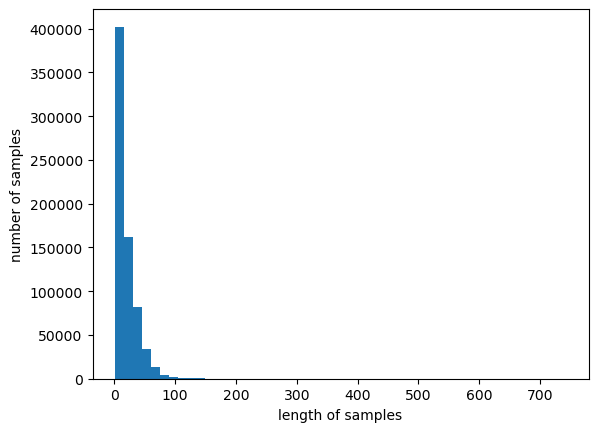

In [ ]:
# 전체 데이터의 길이 분포를 확인
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 케라스 토크나이저를 통해서 정수 인코딩을 진행
# 모든 단어를 사용하며 인덱스 1에는 단어 'OOV'를 할당.
src_tokenizer = Tokenizer(oov_token='OOV')
# 태깅 정보들은 내부적으로 대문자를 유지한 채 저장
tar_tokenizer = Tokenizer(lower=False)

src_tokenizer.fit_on_texts(sentences)
tar_tokenizer.fit_on_texts(ner_tags)

In [ ]:
# 문장 데이터에 대해서는 src_tokenizer를, 레이블에 해당되는 개체명 태깅 정보에 대해서는 tar_tokenizer를 사용
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 581582
개체명 태깅 정보 집합의 크기 : 152


In [ ]:
# 앞서 src_tokenizer를 만들때 Tokenizer의 인자로 oov_token='OOV'를 선택
# 인덱스1에 단어 'OOV'가 할당
print('단어 OOV의 인덱스 : {}'.format(src_tokenizer.word_index['OOV']))

단어 OOV의 인덱스 : 1


In [ ]:
# 정수 인코딩을 수행
X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

In [ ]:
# 문장 데이터에 대해서 정수 인코딩이 수행된 결과는 X_data, 개체명 태깅 데이터에 대해서 정수 인코딩이 수행된 결과는 y_data에 저장
# 정수 인코딩이 되었는지 확인을 위해 임의로 첫번째 샘플을 출력
print(X_data[0])
print(y_data[0])

[195215, 31093, 3375]
[116, 1, 1]


In [ ]:
# 모델 훈련 후 결과 확인을 위해 인덱스로부터 단어를 리턴하는 index_to_word와 인덱스로부터 개체명 태깅 정보를 리턴하는 index_to_ner를 만듦
# 인덱스 0은 'PAD'란 단어를 할당
# index_to_ner은 개수가 적으니 출력
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

print(index_to_ner)

{1: 'O', 2: 'PS_NAME', 3: 'CV_FOOD', 4: 'OGG_FOOD', 5: 'OGG_ECONOMY', 6: 'QT_COUNT', 7: 'DT_OTHERS', 8: 'LC_OTHERS', 9: 'AFW_OTHER_PRODUCTS', 10: 'QT_PRICE', 11: 'AFA_VIDEO', 12: 'DT_DURATION', 13: 'PS_CHARACTER', 14: 'QT_ORDER', 15: 'CV_DRINK', 16: 'QT_PERCENTAGE', 17: 'CV_POSITION', 18: 'AFA_DOCUMENT', 19: 'QT_MAN_COUNT', 20: 'LCP_COUNTY', 21: 'OGG_POLITICS', 22: 'AF_BUILDING', 23: 'EV_OTHERS', 24: 'OGG_OTHERS', 25: 'TI_DURATION', 26: 'AFA_MUSIC', 27: 'QT_OTHERS', 28: 'CV_OCCUPATION', 29: 'TMI_HW', 30: 'TMI_SERVICE', 31: 'TMM_DISEASE', 32: 'EV_FESTIVAL', 33: 'QT_AGE', 34: 'DT_YEAR', 35: 'OGG_EDUCATION', 36: 'LCP_CITY', 37: 'QT_LENGTH', 38: 'AF_TRANSPORT', 39: 'CV_CLOTHING', 40: 'TI_OTHERS', 41: 'OGG_SPORTS', 42: 'QT_SPORTS', 43: 'OGG_ART', 44: 'EV_SPORTS', 45: 'MT_CHEMICAL', 46: 'CV_ART', 47: 'AF_ROAD', 48: 'CV_LAW', 49: 'TM_CELL_TISSUE_ORGAN', 50: 'TR_SCIENCE', 51: 'DT_DAY', 52: 'TMI_SITE', 53: 'AM_PART', 54: 'PS_PET', 55: 'QT_WEIGHT', 56: 'AF_CULTURAL_ASSET', 57: 'CV_RELATION', 58:

In [ ]:
# index_to_word를 통해 첫번째 샘플의 정수 시퀀스를 텍스트 시퀀스로 변환하는 디코딩 작업 수행
decoded = []
for index in X_data[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존의 문장 : {}'.format(sentences[0]))
print('디코딩 문장 : {}'.format(decoded))

기존의 문장 : ['#0011', '도교', '킹']
디코딩 문장 : ['#0011', '도교', '킹']


In [ ]:
# X 데이터와 y 데이터가 구성됨
# 패딩 작업을 진행
# 가장 긴 샘플의 길이인 100(최대 1486)으로 max_len 설정
max_len = 100
X_data = pad_sequences(X_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)

In [ ]:
# 모든 샘플의 길이가 100이 됨. 훈련 데이터와 테스트 데이터를 9:1의 비율로 분리
X_train, X_test, y_train_int, y_test_int = train_test_split(X_data, y_data, test_size=.1, random_state=42)

In [ ]:
# 레이블에 해당하는 태깅 정보에 대해서 원-핫 인코딩을 수행
y_train = to_categorical(y_train_int, num_classes=tag_size)
y_test = to_categorical(y_test_int, num_classes=tag_size)

In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_train_int.shape))
print('훈련 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_test_int.shape))
print('테스트 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (561649, 100)
훈련 샘플 레이블(정수 인코딩)의 크기 : (561649, 100)
훈련 샘플 레이블(원-핫 인코딩)의 크기 : (561649, 100, 152)
테스트 샘플 문장의 크기 : (140413, 100)
테스트 샘플 레이블(정수 인코딩)의 크기 : (140413, 100)
테스트 샘플 레이블(원-핫 인코딩)의 크기 : (140413, 100, 152)


# 2. 양방향 LSTM(Bi-directional LSTM)으로 개체명 인식기 만들기

- Model 생성
    - Sequential
        - 원하는 layer를 순차적으로 추가하는 방식
        - 직관적인 model을 빠르게 구현할 수 있지만 복잡한 구조의 구현이 힘듦
    - Functional
        - input layer부터 output layer까지 직접 forward 순서대로 함수 끝에 입벽 변수를 넣어줌
        - Model(inputs, outputs)
    - Subclassing
        - pytorch와 구현 방식이 비슷
        - 직접 model class를 생성하고 model module을 상속받음
        - __init__ 함수 : 사용할 layer들을 작성
        - call 함수 : __init__에서 작성한 layer에 맞게 forward

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

In [ ]:
embedding_dim = 128
hidden_units = 256

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=128, epochs=6, validation_split=0.1)

Epoch 1/6
3950/3950 [==============================] - 3460s 874ms/step - loss: 0.0522 - accuracy: 0.9490 - val_loss: 0.0384 - val_accuracy: 0.9549
Epoch 2/6
3950/3950 [==============================] - 3539s 896ms/step - loss: 0.0250 - accuracy: 0.9680 - val_loss: 0.0278 - val_accuracy: 0.9651
Epoch 3/6
3950/3950 [==============================] - 3490s 884ms/step - loss: 0.0105 - accuracy: 0.9847 - val_loss: 0.0288 - val_accuracy: 0.9659
Epoch 4/6
3950/3950 [==============================] - 3482s 882ms/step - loss: 0.0067 - accuracy: 0.9888 - val_loss: 0.0303 - val_accuracy: 0.9650
Epoch 5/6
3950/3950 [==============================] - 3507s 888ms/step - loss: 0.0052 - accuracy: 0.9905 - val_loss: 0.0331 - val_accuracy: 0.9640
Epoch 6/6
3950/3950 [==============================] - 3494s 885ms/step - loss: 0.0042 - accuracy: 0.9917 - val_loss: 0.0346 - val_accuracy: 0.9634


In [ ]:
from keras.models import load_model

model.save('entity_bilstm_model.h5')

In [ ]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 인코딩으로 변경함.
labels = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

1/1 [==============================] - 0s 45ms/step
단어             |실제값  |예측값
-----------------------------------
이                : O       O
부분               : O       O
을                : O       O
'                : O       O
비로소              : O       O
제도               : O       O
가                : O       O
제대로              : O       O
갖춰졌기             : O       O
때문               : O       O
에                : O       O
은나라              : O       DT_DYNASTY
의                : O       O
소박한              : O       O
문화               : O       O
가                : O       O
주나라              : DT_DYNASTY O
에                : O       O
와서               : O       O
훨씬               : O       O
세련되어졌다           : O       O
.                : O       O


In [ ]:
labels = ['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
predicted = ['O'] * len(labels) 
print('예측값 :',predicted)

예측값 : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
hit = 0 # 정답 개수
for tag, pred in zip(labels, predicted):
    if tag == pred:
        hit +=1 # 정답인 경우에만 +1
accuracy = hit/len(labels) # 정답 개수를 총 개수로 나눈다.
print("정확도: {:.1%}".format(accuracy))

정확도: 74.4%


In [ ]:
from seqeval.metrics import classification_report
print(classification_report([labels], [predicted]))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         2
         PER       0.00      0.00      0.00         3

   micro avg       0.00      0.00      0.00         5
   macro avg       0.00      0.00      0.00         5
weighted avg       0.00      0.00      0.00         5



c:\Anaconda3\envs\nlp-dev\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda3\envs\nlp-dev\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
labels = ['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
predicted = ['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O']

print(classification_report([labels], [predicted]))

              precision    recall  f1-score   support

        MISC       1.00      0.50      0.67         2
         PER       1.00      0.67      0.80         3

   micro avg       1.00      0.60      0.75         5
   macro avg       1.00      0.58      0.73         5
weighted avg       1.00      0.60      0.75         5



# 4. F1-score로 성능 측정하기

In [ ]:
from seqeval.metrics import f1_score, classification_report

In [ ]:
def sequences_to_tag(sequences):
    result = []
    # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
    for sequence in sequences:
        word_sequence = []
        # 시퀀스로부터 확률 벡터 또는 원-핫 벡터를 하나씩 꺼낸다.
        for pred in sequence:
            # 정수로 변환. 예를 들어 pred가 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            pred_index = np.argmax(pred)            
            # index_to_ner을 사용하여 정수를 태깅 정보로 변환. 'PAD'는 'O'로 변경.
            word_sequence.append(index_to_ner[pred_index].replace("PAD", "O"))
        result.append(word_sequence)
    return result

y_predicted = model.predict([X_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))
print(classification_report(test_tags, pred_tags))

4388/4388 [==============================] - 298s 67ms/step


c:\Anaconda3\envs\nlp-dev\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: TI_DURATION seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Anaconda3\envs\nlp-dev\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: AF_CULTURAL_ASSET seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Anaconda3\envs\nlp-dev\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: PS_NAME seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Anaconda3\envs\nlp-dev\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: OGG_FOOD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Anaconda3\envs\nlp-dev\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: EV_OTHERS seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Anaconda3\envs\nlp-dev\li

F1-score: 32.1%
                      precision    recall  f1-score   support

              CG_BAY       0.59      0.36      0.44        45
        CG_CONTINENT       0.48      0.42      0.45        76
           CG_ISLAND       0.58      0.43      0.50       267
         CG_MOUNTAIN       0.49      0.47      0.48       317
            CG_OCEAN       0.30      0.28      0.29        57
            CG_RIVER       0.63      0.48      0.55       222
      CP_CAPITALCITY       0.49      0.49      0.49       176
             CP_CITY       0.39      0.36      0.37      1016
          CP_COUNTRY       0.36      0.36      0.36       486
           CP_COUNTY       0.42      0.38      0.40      1785
         CP_PROVINCE       0.41      0.30      0.35       368
            C_OTHERS       0.65      0.45      0.53      3814
             C_SPACE       0.46      0.40      0.43       151
               D_ART       0.29      0.15      0.19        48
        D_HUMANITIES       0.61      0.24      0.34  

# 1. CRF(Conditional Random Field)
- B-Per, I-Per, B-Org, I-Org, O

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional, TimeDistributed, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_crf import CRFModel
from seqeval.metrics import f1_score, classification_report

In [ ]:
# 모델 불러오기
from keras.models import load_model
model = load_model('entity_bilstm_model.h5')

In [ ]:
embedding_dim = 128
hidden_units = 64
dropout_ratio = 0.3

sequence_input = Input(shape=(max_len,),dtype=tf.int32, name='sequence_input')

model_embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_len)(sequence_input)

model_bilstm = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(model_embedding)

model_dropout = TimeDistributed(Dropout(dropout_ratio))(model_bilstm)

model_dense = TimeDistributed(Dense(tag_size, activation='relu'))(model_dropout)

base = Model(inputs=sequence_input, outputs=model_dense)
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_crf/cp.ckpt', monitor='val_decode_sequence_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

history = model.fit(X_train, y_train_int, batch_size=128, epochs=15, validation_split=0.1, callbacks=[mc, es])

Epoch 1/15
3950/3950 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9882 - loss: 7.3001
Epoch 1: val_decode_sequence_accuracy improved from -inf to 0.99127, saving model to bilstm_crf\cp.ckpt
3950/3950 [==============================] - 3405s 861ms/step - decode_sequence_accuracy: 0.9882 - loss: 7.2995 - val_decode_sequence_accuracy: 0.9913 - val_loss: 3.9657
Epoch 2/15
3950/3950 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9931 - loss: 2.9465
Epoch 2: val_decode_sequence_accuracy improved from 0.99127 to 0.99306, saving model to bilstm_crf\cp.ckpt
3950/3950 [==============================] - 3326s 842ms/step - decode_sequence_accuracy: 0.9931 - loss: 2.9462 - val_decode_sequence_accuracy: 0.9931 - val_loss: 2.7247
Epoch 3/15
3950/3950 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9961 - loss: 1.5670
Epoch 3: val_decode_sequence_accuracy improved from 0.99306 to 0.99358, saving model to bilstm_crf\cp.ckpt


In [ ]:
model.load_weights('bilstm_crf/cp.ckpt')

i =103 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]]))[0] # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
labels = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

1/1 [==============================] - 0s 25ms/step
단어             |실제값  |예측값
-----------------------------------
이비에스             : OGG_EDUCATION O
스쿨               : O       O
리포터              : O       O
김민주              : O       PS_NAME
입니다              : O       O
.                : O       O


In [ ]:
y_predicted = model.predict(X_test)[0]

4388/4388 [==============================] - 442s 101ms/step


In [ ]:
print(y_predicted[:2])

[[3 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [ ]:
def sequences_to_tag_for_crf(sequences): 
    result = []
    # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
    for sequence in sequences: 
        word_sequence = []
        # 시퀀스로부터 예측 정수 레이블을 하나씩 꺼낸다.
        for pred_index in sequence:
            # index_to_ner을 사용하여 정수를 태깅 정보로 변환. 'PAD'는 'O'로 변경.
            word_sequence.append(index_to_ner[pred_index].replace("PAD", "O"))
        result.append(word_sequence)
    return result

pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))
print(classification_report(test_tags, pred_tags))

F1-score: 52.6%
                      precision    recall  f1-score   support

              CG_BAY       0.56      0.20      0.30        45
        CG_CONTINENT       0.86      0.16      0.27        76
           CG_ISLAND       0.65      0.38      0.48       267
         CG_MOUNTAIN       0.55      0.39      0.45       317
            CG_OCEAN       0.35      0.12      0.18        57
            CG_RIVER       0.66      0.43      0.52       222
      CP_CAPITALCITY       0.54      0.45      0.49       176
             CP_CITY       0.45      0.31      0.37      1016
          CP_COUNTRY       0.63      0.20      0.31       486
           CP_COUNTY       0.39      0.42      0.40      1785
         CP_PROVINCE       0.63      0.20      0.30       368
            C_OTHERS       0.64      0.46      0.54      3814
             C_SPACE       0.73      0.29      0.42       151
               D_ART       0.75      0.06      0.12        48
        D_HUMANITIES       0.64      0.18      0.29  